# Global Power Rankings Hackathon

### Team Solo Dev - Kanisk Chakraborty (devkanisk)

#### Problem Statement

To create 3 endpoints that are to do the following:

**1. Tournament rankings - get team rankings for a given tournament**

```
GET /tournament_rankings/{tournament_id}

Parameters

tournament_id string (path) *required ID of tournament to return rankings for

stage string (query) Stage of tournament to return rankings for

Note: the rankings should be relevant for the time period of a tournament, i.e. if Worlds 2021 is queried here the rankings should be given for the teams at the time of the competition. So if your ranking has a weighted win/loss scoring from the past six months, you should use the six months prior to the start of Worlds 2021.
```

**2. Global Rankings**

```
Global rankings - get current top X teams globally

GET /global_rankings

Parameters

number_of_teams integer (query) - number of teams to return a ranking for, the default is 20
```

**3. Team Rankings from given list of teams**

```
Team rankings - get rankings from a given list of teams

GET /team_rankings/

Parameters

team_ids array[string] (query) *required IDs of tournaments to return ranking for
```

> NOTE: Team rankings and Global rankings query for the current state of affairs, but Tournament rankings should be weighted

### Additional Info—10/19/2023

- Tournament rankings: your method should return a ranking for any of the tournaments from a MSI/Worlds qualifying region for 2022-2023
- Global and team rankings: your method only needs to consider teams that have participated in a MSI/Worlds qualifying region in 2023
- List of regions: LPL, LEC, LCK, LCS, PCS, VCS, CBLOL, LJL, LLA

In [183]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import os
import json

First, let's count the number of tournament CSV files we have...

In [157]:
folder_path = "../esports-data/created/mapped-games-flattened"
csv_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]
len(csv_files)

42

For the year 2023 and 2022, our extraction methods have retained information from 42 tournaments across the LPL, LEC, LCK, LCS, PCS, VCS, CBLOL, LJL, LLA + Worlds 2022 + MSI 2023 and 2022 tournaments.

Let's see how many total games we have now!

In [158]:
import csv

def count_rows_in_csv(csv_file_path):
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)  # skip the header
        return sum(1 for row in reader)
    
num_games = 0
for file in csv_files:
    num_games += count_rows_in_csv(os.path.join(folder_path, file))

num_games

4864

We've got 4864 games from the mapping data!

In [159]:
lcs_folder_path = "../esports-data/created/mapped-games/98767991299243165"
lcs_csv_files = [f for f in os.listdir(lcs_folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]
num_lcs_games = 0
for file in lcs_csv_files:
    num_lcs_games += count_rows_in_csv(os.path.join(folder_path, file))
num_lcs_games

567

Just for a sample size, these are the num LCS games for 2022, 2023. Not bad!

## EDA of Tournament Data

Let's now dive into analysis of an individual tournament file and look at all the invidual game data that we've aggregated. From there we will look to pick the key indicators to be used as features for our model.

For our example, we'll take a look at Worlds 2022 data.

[Worlds 2022 Final Game 5](https://www.youtube.com/watch?v=gapSIdUT8Us) for throwback! 

In [165]:
worlds_2022 = pd.read_csv("../esports-data/created/mapped-games-flattened/worlds_2022.csv")

In [166]:
worlds_2022.head()

,league_id,tournament_id,tournament_name,tournament_slug,tournament_start_date,tournament_end_date,platform_game_id,game_id,game_number,stage_name,stage_slug,section_name,game_date,game_duration,game_patch,team_first_turret_destroyed,lane_first_turret_destroyed,team_first_blood,team_100_blue_id,team_200_red_id,team_100_blue_name,team_200_red_name,game_winner,1_100_top_summonerName,1_100_top_championName,2_100_jng_summonerName,2_100_jng_championName,3_100_mid_summonerName,3_100_mid_championName,4_100_adc_summonerName,4_100_adc_championName,5_100_sup_summonerName,5_100_sup_championName,6_200_top_summonerName,6_200_top_championName,7_200_jng_summonerName,7_200_jng_championName,8_200_mid_summonerName,8_200_mid_championName,9_200_adc_summonerName,9_200_adc_championName,10_200_sup_summonerName,10_200_sup_championName,team_first_dragon_kill,first_dragon_type,team_first_baron_kill,team_first_herald_kill,num_heralds_secured_blue,num_heralds_secured_red,is_dragon_soul_collected,team_first_dragon_soul,dragon_soul_collected,is_elder_dragon_collected,team_first_elder_dragon,1_100_top_level_300,1_100_top_totalGold_300,1_100_top_MINIONS_KILLED_300,100_total_MINIONS_KILLED_300,1_100_top_NEUTRAL_MINIONS_KILLED_300,100_total_NEUTRAL_MINIONS_KILLED_300,1_100_top_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,100_total_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,1_100_top_CHAMPIONS_KILLED_300,100_total_CHAMPIONS_KILLED_300,1_100_top_NUM_DEATHS_300,100_total_NUM_DEATHS_300,1_100_top_ASSISTS_300,100_total_ASSISTS_300,1_100_top_WARD_PLACED_300,100_total_WARD_PLACED_300,1_100_top_WARD_KILLED_300,100_total_WARD_KILLED_300,1_100_top_VISION_SCORE_300,100_total_VISION_SCORE_300,1_100_top_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,100_total_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,1_100_top_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,100_total_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,1_100_top_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,100_total_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,1_100_top_TIME_CCING_OTHERS_300,100_total_TIME_CCING_OTHERS_300,2_100_jng_level_300,2_100_jng_totalGold_300,2_100_jng_MINIONS_KILLED_300,2_100_jng_NEUTRAL_MINIONS_KILLED_300,2_100_jng_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,2_100_jng_CHAMPIONS_KILLED_300,2_100_jng_NUM_DEATHS_300,2_100_jng_ASSISTS_300,2_100_jng_WARD_PLACED_300,2_100_jng_WARD_KILLED_300,2_100_jng_VISION_SCORE_300,2_100_jng_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,2_100_jng_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,2_100_jng_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,2_100_jng_TIME_CCING_OTHERS_300,3_100_mid_level_300,3_100_mid_totalGold_300,3_100_mid_MINIONS_KILLED_300,3_100_mid_NEUTRAL_MINIONS_KILLED_300,3_100_mid_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,3_100_mid_CHAMPIONS_KILLED_300,3_100_mid_NUM_DEATHS_300,3_100_mid_ASSISTS_300,3_100_mid_WARD_PLACED_300,3_100_mid_WARD_KILLED_300,3_100_mid_VISION_SCORE_300,3_100_mid_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,3_100_mid_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,3_100_mid_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,3_100_mid_TIME_CCING_OTHERS_300,4_100_adc_level_300,4_100_adc_totalGold_300,4_100_adc_MINIONS_KILLED_300,4_100_adc_NEUTRAL_MINIONS_KILLED_300,4_100_adc_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,4_100_adc_CHAMPIONS_KILLED_300,4_100_adc_NUM_DEATHS_300,4_100_adc_ASSISTS_300,4_100_adc_WARD_PLACED_300,4_100_adc_WARD_KILLED_300,4_100_adc_VISION_SCORE_300,4_100_adc_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,4_100_adc_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,4_100_adc_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,4_100_adc_TIME_CCING_OTHERS_300,5_100_sup_level_300,5_100_sup_totalGold_300,5_100_sup_MINIONS_KILLED_300,5_100_sup_NEUTRAL_MINIONS_KILLED_300,5_100_sup_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_300,5_100_sup_CHAMPIONS_KILLED_300,5_100_sup_NUM_DEATHS_300,5_100_sup_ASSISTS_300,5_100_sup_WARD_PLACED_300,5_100_sup_WARD_KILLED_300,5_100_sup_VISION_SCORE_300,5_100_sup_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_300,5_100_sup_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_300,5_100_sup_TOTAL_TIME_CROWD_CONTROL_DEALT_TO_CHAMPIONS_300,5_10

### Wins, Gold differences and Kills

In [168]:
unique_teams_blue = worlds_2022['team_100_blue_name'].unique()
unique_teams_red = worlds_2022['team_200_red_name'].unique()

# combine and find unique teams
all_unique_teams = list(set(unique_teams_blue) | set(unique_teams_red))

# mapping the winning side to the team names
worlds_2022['winning_team'] = worlds_2022.apply(
    lambda row: row['team_100_blue_name'] if row['game_winner'] == 100 else row['team_200_red_name'], axis=1)

# calculate wins for each team
team_wins_corrected = worlds_2022.groupby('winning_team').size()

team_wins_df_corrected = pd.DataFrame({'Team': all_unique_teams})
team_wins_df_corrected['Wins'] = team_wins_df_corrected['Team'].map(team_wins_corrected).fillna(0).astype(int)

team_wins_df_corrected.sort_values(by='Wins', ascending=False)

,Team,Wins
10,DRX,19
2,Royal Never Give Up,12
5,T1,12
3,Gen.G,10
18,Beijing JDG Intel Esports Club,10
23,Evil Geniuses LG,9
1,DetonatioN FocusMe,7
21,SHANGHAI EDWARD GAMING HYCAN,6
20,MAD Lions,6
17,Fnatic,6


Now we have a clearer picture of the number of wins each team has achieved in this tournament. DRX leads with 19 wins, followed closely by Royal Never Give Up and T1 with 12 wins each.

Next, let's explore some key performance metrics to get a better understanding of the teams' in-game performances. We'll start by analyzing:

- Gold difference at the end of the game.
- Kill difference at the end of the game.
- Objective control metrics, such as dragon, baron, tower, and inhibitor kills.

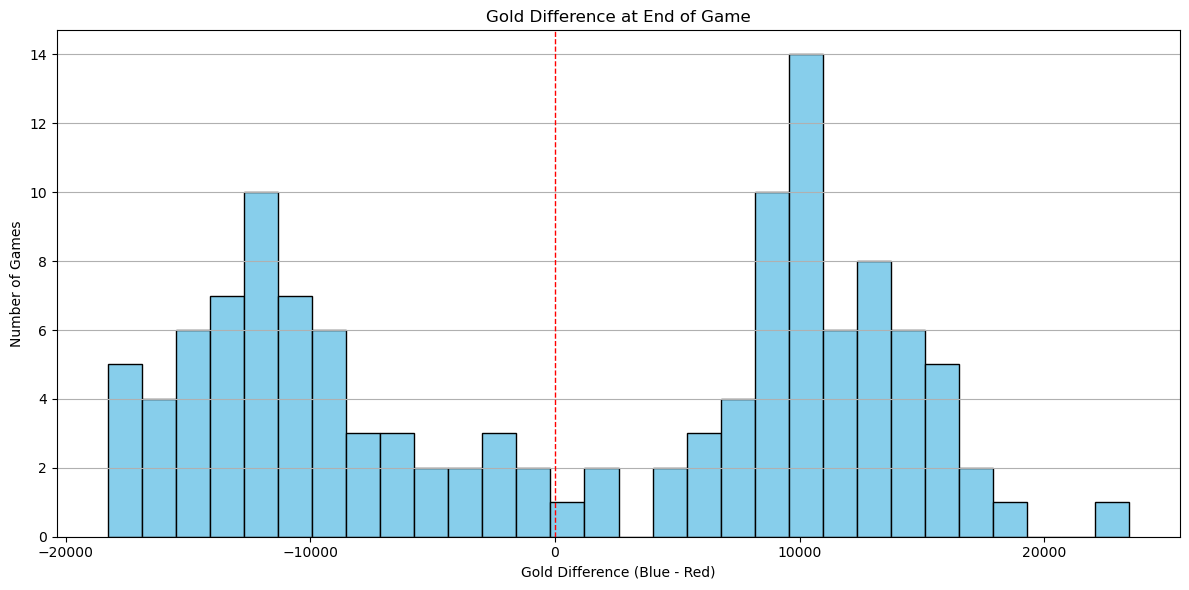

In [170]:
# calculate gold difference at the end of the game
worlds_2022['gold_diff_end'] = worlds_2022['100_blue_totalGold_game_end'] - worlds_2022['200_red_totalGold_game_end']

# plotting the gold difference
plt.figure(figsize=(12, 6))
plt.hist(worlds_2022['gold_diff_end'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Gold Difference at End of Game")
plt.xlabel("Gold Difference (Blue - Red)")
plt.ylabel("Number of Games")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The histogram showcases the distribution of gold differences at the end of games. A few key observations:
1. The majority of games have a relatively close gold difference, as indicated by the peak around zero.
2. There are games where the blue side (team 100) had a significant gold advantage, as well as games where the red side (team 200) dominated in terms of gold.
3. The red vertical line at 0 indicates games with equal gold for both teams, though this is a rare occurrence.

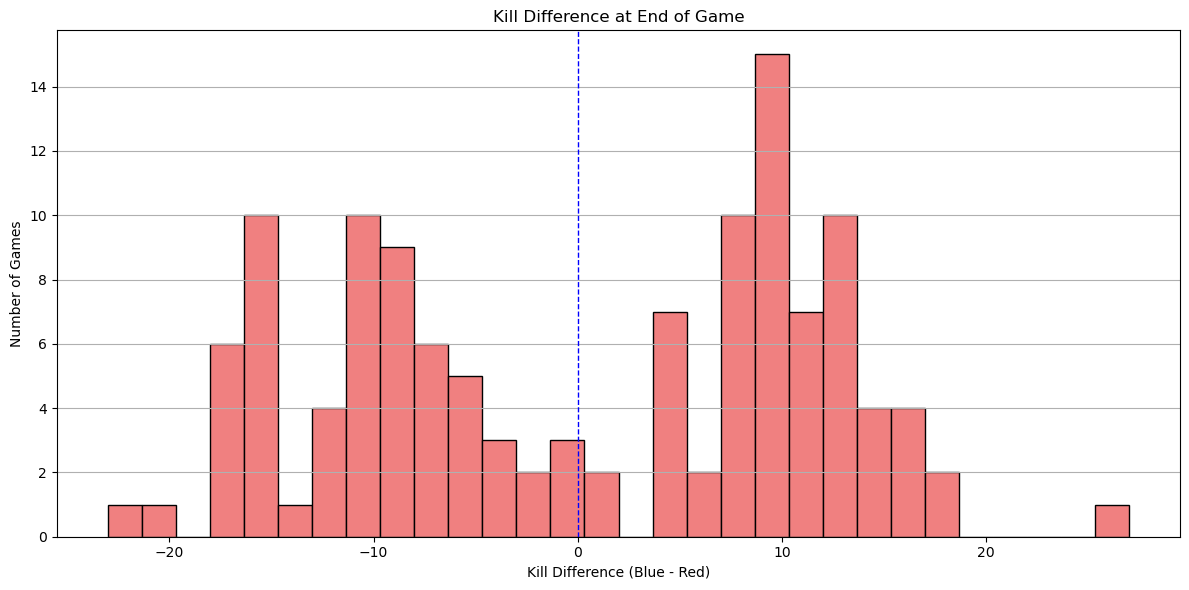

In [174]:
# calculate kill difference at the end of the game
worlds_2022['kill_diff_end'] = worlds_2022['100_blue_championsKills_game_end'] - worlds_2022['200_red_championsKills_game_end']

# plotting the kill difference
plt.figure(figsize=(12, 6))
plt.hist(worlds_2022['kill_diff_end'], bins=30, color='lightcoral', edgecolor='black')
plt.axvline(x=0, color='blue', linestyle='--', linewidth=1)
plt.title("Kill Difference at End of Game")
plt.xlabel("Kill Difference (Blue - Red)")
plt.ylabel("Number of Games")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The histogram showcases the distribution of kill differences at the end of games. Some observations:
1. A significant number of games are close in terms of kill count, but there are also games with pronounced kill differences.
2. Both the blue side (team 100) and the red side (team 200) have had games where they secured a large kill lead.
3. The blue vertical line at 0 represents games where both teams had an equal number of kills, which, again, is rare.

### Objective Control Metrics

Objective control is crucial in League of Legends, as securing dragons, barons, towers, and inhibitors can significantly influence the game's outcome. Let's visualize the total counts of these objectives for winning teams to gain insights into their importance.

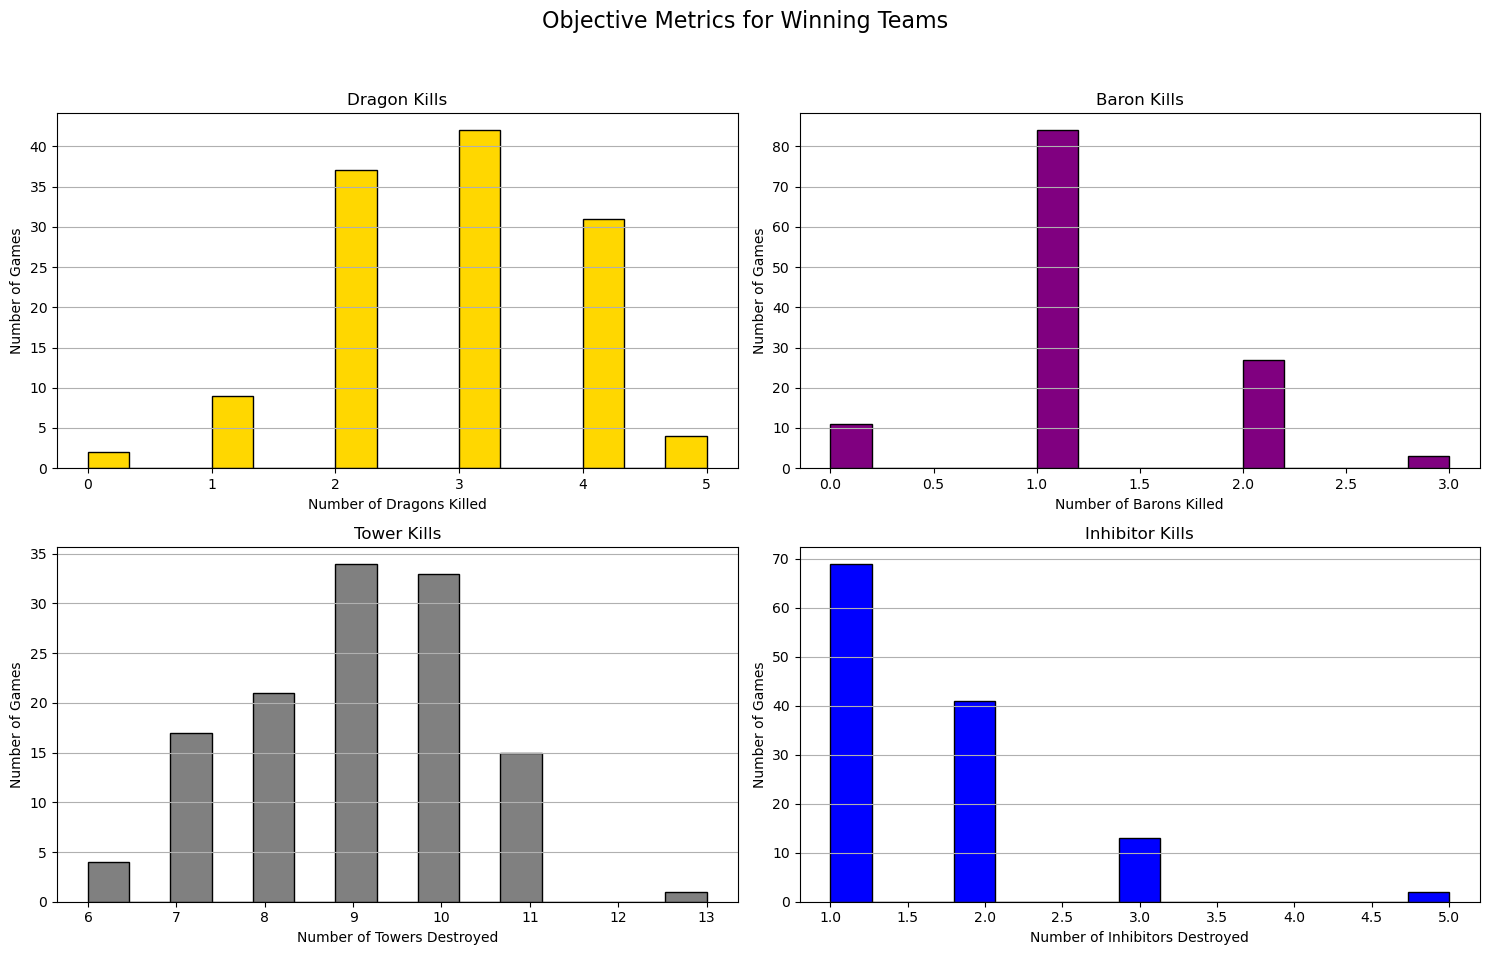

In [175]:
# extracting objective metrics for winning teams
worlds_2022['winning_dragonKills'] = worlds_2022.apply(lambda x: x['100_blue_dragonKills_game_end'] if x['game_winner'] == 100 else x['200_red_dragonKills_game_end'], axis=1)
worlds_2022['winning_baronKills'] = worlds_2022.apply(lambda x: x['100_blue_baronKills_game_end'] if x['game_winner'] == 100 else x['200_red_baronKills_game_end'], axis=1)
worlds_2022['winning_towerKills'] = worlds_2022.apply(lambda x: x['100_blue_towerKills_game_end'] if x['game_winner'] == 100 else x['200_red_towerKills_game_end'], axis=1)
worlds_2022['winning_inhibKills'] = worlds_2022.apply(lambda x: x['100_blue_inhibKills_game_end'] if x['game_winner'] == 100 else x['200_red_inhibKills_game_end'], axis=1)

# plotting the objective metrics
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Objective Metrics for Winning Teams", fontsize=16)

# dragon kills
axs[0, 0].hist(worlds_2022['winning_dragonKills'], bins=15, color='gold', edgecolor='black')
axs[0, 0].set_title("Dragon Kills")
axs[0, 0].set_xlabel("Number of Dragons Killed")
axs[0, 0].set_ylabel("Number of Games")
axs[0, 0].grid(axis='y')

# baron kills
axs[0, 1].hist(worlds_2022['winning_baronKills'], bins=15, color='purple', edgecolor='black')
axs[0, 1].set_title("Baron Kills")
axs[0, 1].set_xlabel("Number of Barons Killed")
axs[0, 1].set_ylabel("Number of Games")
axs[0, 1].grid(axis='y')

# tower kills
axs[1, 0].hist(worlds_2022['winning_towerKills'], bins=15, color='gray', edgecolor='black')
axs[1, 0].set_title("Tower Kills")
axs[1, 0].set_xlabel("Number of Towers Destroyed")
axs[1, 0].set_ylabel("Number of Games")
axs[1, 0].grid(axis='y')

# inhibitor kills
axs[1, 1].hist(worlds_2022['winning_inhibKills'], bins=15, color='blue', edgecolor='black')
axs[1, 1].set_title("Inhibitor Kills")
axs[1, 1].set_xlabel("Number of Inhibitors Destroyed")
axs[1, 1].set_ylabel("Number of Games")
axs[1, 1].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The histograms provide insights into the objective control of winning teams:
1. Dragon Kills: Most winning teams have secured between 2 to 4 dragons in their games. Very few games saw a team winning without securing any dragons, emphasizing the importance of dragon control.
2. Baron Kills: The majority of winning teams have secured at least one baron, with many securing two. This shows the significance of baron control in influencing game outcomes.
3. Tower Kills: Tower destruction is fundamental for map control and pressuring the enemy. Most winning teams have destroyed between 7 to 11 towers, reflecting their dominance in the game.
4. Inhibitor Kills: All winning teams have to destroy at least one inhibitor, with some even securing all three. Inhibitor control can provide a considerable advantage by spawning super minions.

### ELO Rating System

For the ELO rating system:
1. Start every team with a base rating of 1500.
2. After each game, update the ELO ratings of the participating teams based on the outcome and the difference in ratings between the teams.

In [178]:
def update_elo(winner_elo, loser_elo, k=30):
    """
    Update the ELO ratings based on the game outcome.
    
    Parameters:
    - winner_elo: ELO rating of the winning team before the game.
    - loser_elo: ELO rating of the losing team before the game.
    - k: K-factor (default is 30), determines the maximum rating change.
    
    Returns:
    - Updated ELO ratings for both the winner and the loser.
    """
    expected_win_winner = 1 / (1 + 10**((loser_elo - winner_elo) / 400))
    expected_win_loser = 1 / (1 + 10**((winner_elo - loser_elo) / 400))
    
    new_winner_elo = winner_elo + k * (1 - expected_win_winner)
    new_loser_elo = loser_elo + k * (0 - expected_win_loser)
    
    return new_winner_elo, new_loser_elo

elo_ratings = {team: 1500 for team in all_unique_teams}

# update ELO ratings for each game
for index, row in worlds_2022.iterrows():
    winner = row['winning_team']
    loser = row['team_100_blue_name'] if winner != row['team_100_blue_name'] else row['team_200_red_name']
    
    new_winner_elo, new_loser_elo = update_elo(elo_ratings[winner], elo_ratings[loser])
    
    elo_ratings[winner] = new_winner_elo
    elo_ratings[loser] = new_loser_elo

# convert ELO ratings to DataFrame for better visualization
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=['Team', 'ELO Rating']).sort_values(by='ELO Rating', ascending=False)
elo_df.reset_index(drop=True, inplace=True)
elo_df

,Team,ELO Rating
0,DRX,1644.298430
1,T1,1603.386857
2,Beijing JDG Intel Esports Club,1590.104278
3,Gen.G,1569.253497
4,Royal Never Give Up,1541.315566
5,Dplus Kia,1525.844123
6,SHANGHAI EDWARD GAMING HYCAN,1521.427683
7,Evil Geniuses LG,1513.244934
8,TOP ESPORTS,1507.019305
9,DetonatioN FocusMe,1506.031532


### Per Tournament Info

Let's take a sample tournament to gather info from. For our purposes, we'll use Worlds 2022.

In [151]:
worlds_2022_df = pd.read_csv("../esports-data/created/mapped-games-flattened/worlds_2022.csv")

In [152]:
worlds_2022_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 822 entries, league_id to 200_red_towerKills_game_end
dtypes: float64(624), int64(166), object(32)
memory usage: 802.9+ KB


In [156]:
worlds_2022_df.shape[0]

125

Extract all unique teams partaking in the tournament

In [153]:
unique_teams_blue = worlds_2022_df['team_100_blue_name'].unique()
unique_teams_red = worlds_2022_df['team_200_red_name'].unique()

all_unique_teams = set(list(unique_teams_blue) + list(unique_teams_red))

all_unique_teams

{'100 Thieves',
 'Beijing JDG Intel Esports Club',
 'Beyond Gaming',
 'CTBC Flying Oyster',
 'Cloud9',
 'DRX',
 'DenizBank İstanbul Wildcats',
 'DetonatioN FocusMe',
 'Dplus Kia',
 'Evil Geniuses LG',
 'Fnatic',
 'G2 Esports',
 'GAM Esports',
 'Gen.G',
 'Isurus',
 'KOI',
 'LOUD',
 'MAD Lions',
 'Royal Never Give Up',
 'SHANGHAI EDWARD GAMING HYCAN',
 'Saigon Buffalo Esports',
 'T1',
 'TOP ESPORTS',
 'The Chiefs'}

In [154]:
wins = {team: 0 for team in all_unique_teams}
losses = {team: 0 for team in all_unique_teams}

for index, row in worlds_2022_df.iterrows():
    if row['game_winner'] == 100:
        wins[row['team_100_blue_name']] += 1
        losses[row['team_200_red_name']] += 1
    else:
        wins[row['team_200_red_name']] += 1
        losses[row['team_100_blue_name']] += 1

team_records_updated = pd.DataFrame({
    'Team': list(all_unique_teams),
    'Wins': [wins[team] for team in all_unique_teams],
    'Losses': [losses[team] for team in all_unique_teams]
})

team_records_updated.sort_values(by='Wins', ascending=False)

,Team,Wins,Losses
10,DRX,19,7
2,Royal Never Give Up,12,7
5,T1,12,5
3,Gen.G,10,5
18,Beijing JDG Intel Esports Club,10,3
23,Evil Geniuses LG,9,7
1,DetonatioN FocusMe,7,7
21,SHANGHAI EDWARD GAMING HYCAN,6,5
20,MAD Lions,6,6
17,Fnatic,6,5


#### Calculate Win Rate

In [85]:
team_records_updated['Win Rate'] = team_records_updated['Wins'] / (team_records_updated['Wins'] + team_records_updated['Losses'])

# Compute Gold Differential for each team
worlds_2022_df['Gold Differential'] = worlds_2022_df['100_blue_totalGold_game_end'] - worlds_2022_df['200_red_totalGold_game_end']

# Calculate average gold differential for each team when they are on the blue side and red side
blue_gold_diff = worlds_2022_df.groupby('team_100_blue_name')['Gold Differential'].mean()
red_gold_diff = -worlds_2022_df.groupby('team_200_red_name')['Gold Differential'].mean()  # Negative since it's from the red side's perspective

# Average the gold differentials for each team across blue and red sides
gold_differentials = (blue_gold_diff.add(red_gold_diff, fill_value=0)) / 2

# Add this to our main dataframe
team_records_updated['Avg Gold Differential'] = team_records_updated['Team'].map(gold_differentials)

team_records_updated[['Team', 'Win Rate', 'Avg Gold Differential']].head() 

,Team,Win Rate,Avg Gold Differential
0,LOUD,0.400000,-3056.666667
1,DetonatioN FocusMe,0.500000,-1040.400000
2,Royal Never Give Up,0.631579,4735.744318
3,Gen.G,0.666667,4589.450000
4,Beyond Gaming,0.400000,-4720.833333


Let's compute the Objective Control metric for each team.

For this metric, we'll focus on the following objectives:
- Towers
- Inhibitors
- Dragons
- Barons

For each team, we'll calculate the average number of each of these objectives they secured throughout the tournament. We'll do this for both the blue side and the red side and then compute the overall average.

In [86]:
# Calculate average objectives secured by each team when they are on the blue side
blue_avg_towers = worlds_2022_df.groupby('team_100_blue_name')['100_blue_towerKills_game_end'].mean()
blue_avg_inhibs = worlds_2022_df.groupby('team_100_blue_name')['100_blue_inhibKills_game_end'].mean()
blue_avg_dragons = worlds_2022_df.groupby('team_100_blue_name')['100_blue_dragonKills_game_end'].mean()
blue_avg_barons = worlds_2022_df.groupby('team_100_blue_name')['100_blue_baronKills_game_end'].mean()

# Calculate average objectives secured by each team when they are on the red side
red_avg_towers = worlds_2022_df.groupby('team_200_red_name')['200_red_towerKills_game_end'].mean()
red_avg_inhibs = worlds_2022_df.groupby('team_200_red_name')['200_red_inhibKills_game_end'].mean()
red_avg_dragons = worlds_2022_df.groupby('team_200_red_name')['200_red_dragonKills_game_end'].mean()
red_avg_barons = worlds_2022_df.groupby('team_200_red_name')['200_red_baronKills_game_end'].mean()

# Average the objectives for each team across blue and red sides
team_records_updated['Avg Tower Kills'] = (team_records_updated['Team'].map(blue_avg_towers).fillna(0) + 
                                           team_records_updated['Team'].map(red_avg_towers).fillna(0)) / 2
team_records_updated['Avg Inhibitor Kills'] = (team_records_updated['Team'].map(blue_avg_inhibs).fillna(0) + 
                                               team_records_updated['Team'].map(red_avg_inhibs).fillna(0)) / 2
team_records_updated['Avg Dragon Kills'] = (team_records_updated['Team'].map(blue_avg_dragons).fillna(0) + 
                                            team_records_updated['Team'].map(red_avg_dragons).fillna(0)) / 2
team_records_updated['Avg Baron Kills'] = (team_records_updated['Team'].map(blue_avg_barons).fillna(0) + 
                                           team_records_updated['Team'].map(red_avg_barons).fillna(0)) / 2

team_records_updated[['Team', 'Avg Tower Kills', 'Avg Inhibitor Kills', 'Avg Dragon Kills', 'Avg Baron Kills']].head()

,Team,Avg Tower Kills,Avg Inhibitor Kills,Avg Dragon Kills,Avg Baron Kills
0,LOUD,4.642857,0.547619,2.000000,0.595238
1,DetonatioN FocusMe,5.000000,0.688889,1.800000,0.733333
2,Royal Never Give Up,7.056818,1.306818,3.051136,0.801136
3,Gen.G,6.850000,1.050000,2.450000,0.700000
4,Beyond Gaming,3.916667,0.500000,1.833333,0.583333


Next let's calculate Avg KDA for the teams

In [87]:
# Calculate average KDA for each team when they are on the blue side
blue_avg_kills = worlds_2022_df.groupby('team_100_blue_name')['100_blue_championsKills_game_end'].mean()
blue_avg_deaths = worlds_2022_df.groupby('team_100_blue_name')['100_blue_deaths_game_end'].mean()
blue_avg_assists = worlds_2022_df.groupby('team_100_blue_name')['100_blue_assists_game_end'].mean()
blue_kda = (blue_avg_kills + blue_avg_assists) / blue_avg_deaths

# Calculate average KDA for each team when they are on the red side
red_avg_kills = worlds_2022_df.groupby('team_200_red_name')['200_red_championsKills_game_end'].mean()
red_avg_deaths = worlds_2022_df.groupby('team_200_red_name')['200_red_deaths_game_end'].mean()
red_avg_assists = worlds_2022_df.groupby('team_200_red_name')['200_red_assists_game_end'].mean()
red_kda = (red_avg_kills + red_avg_assists) / red_avg_deaths

# Average the KDA for each team across blue and red sides
team_records_updated['Avg KDA'] = (team_records_updated['Team'].map(blue_kda).fillna(0) + 
                                   team_records_updated['Team'].map(red_kda).fillna(0)) / 2

team_records_updated[['Team', 'Avg KDA']].head()  # Displaying a sample for review


,Team,Avg KDA
0,LOUD,2.901091
1,DetonatioN FocusMe,2.867053
2,Royal Never Give Up,4.470018
3,Gen.G,4.842480
4,Beyond Gaming,4.015528


Next, let's calculate Avg Vision Control Score for each team

In [88]:
# Calculate average Vision Control metrics for each team when they are on the blue side
blue_avg_wards_placed = worlds_2022_df.groupby('team_100_blue_name')['100_total_WARD_PLACED_game_end'].mean()
blue_avg_wards_killed = worlds_2022_df.groupby('team_100_blue_name')['100_total_WARD_KILLED_game_end'].mean()

# Calculate average Vision Control metrics for each team when they are on the red side
red_avg_wards_placed = worlds_2022_df.groupby('team_200_red_name')['200_total_WARD_PLACED_game_end'].mean()
red_avg_wards_killed = worlds_2022_df.groupby('team_200_red_name')['200_total_WARD_KILLED_game_end'].mean()

# Average the Vision Control metrics for each team across blue and red sides
team_records_updated['Avg Wards Placed'] = (team_records_updated['Team'].map(blue_avg_wards_placed).fillna(0) + 
                                            team_records_updated['Team'].map(red_avg_wards_placed).fillna(0)) / 2
team_records_updated['Avg Wards Killed'] = (team_records_updated['Team'].map(blue_avg_wards_killed).fillna(0) + 
                                            team_records_updated['Team'].map(red_avg_wards_killed).fillna(0)) / 2

team_records_updated[['Team', 'Avg Wards Placed', 'Avg Wards Killed']].head()  # Displaying a sample for review


,Team,Avg Wards Placed,Avg Wards Killed
0,LOUD,103.904762,35.690476
1,DetonatioN FocusMe,93.455556,46.777778
2,Royal Never Give Up,102.454545,54.977273
3,Gen.G,103.950000,57.700000
4,Beyond Gaming,95.166667,41.000000


The "first" objectives are crucial moments in a game that often indicate which team has the early advantage. They can be strong predictors of overall performance.

Let's calculate the following for each team:
- First Blood
- First Dragon
- First Baron
- First Tower

We'll compute the number of times each team secured these objectives throughout the tournament.

In [89]:
# First Blood
blue_first_blood = worlds_2022_df[worlds_2022_df['team_first_blood'] == 100].groupby('team_100_blue_name').size()
red_first_blood = worlds_2022_df[worlds_2022_df['team_first_blood'] == 200].groupby('team_200_red_name').size()

# First Dragon
blue_first_dragon = worlds_2022_df[worlds_2022_df['team_first_dragon_kill'] == 100].groupby('team_100_blue_name').size()
red_first_dragon = worlds_2022_df[worlds_2022_df['team_first_dragon_kill'] == 200].groupby('team_200_red_name').size()

# First Baron (same as before)
blue_first_baron = worlds_2022_df[worlds_2022_df['team_first_baron_kill'] == 100].groupby('team_100_blue_name').size()
red_first_baron = worlds_2022_df[worlds_2022_df['team_first_baron_kill'] == 200].groupby('team_200_red_name').size()

# First Tower (Turret)
blue_first_tower = worlds_2022_df[worlds_2022_df['team_first_turret_destroyed'] == 100].groupby('team_100_blue_name').size()
red_first_tower = worlds_2022_df[worlds_2022_df['team_first_turret_destroyed'] == 200].groupby('team_200_red_name').size()

# Update the dataframe
team_records_updated['First Bloods'] = team_records_updated['Team'].map(blue_first_blood).fillna(0) + team_records_updated['Team'].map(red_first_blood).fillna(0)
team_records_updated['First Dragons'] = team_records_updated['Team'].map(blue_first_dragon).fillna(0) + team_records_updated['Team'].map(red_first_dragon).fillna(0)
team_records_updated['First Barons'] = team_records_updated['Team'].map(blue_first_baron).fillna(0) + team_records_updated['Team'].map(red_first_baron).fillna(0)
team_records_updated['First Towers'] = team_records_updated['Team'].map(blue_first_tower).fillna(0) + team_records_updated['Team'].map(red_first_tower).fillna(0)

team_records_updated[['Team', 'First Bloods', 'First Dragons', 'First Barons', 'First Towers']].head()  # Displaying a sample for review

,Team,First Bloods,First Dragons,First Barons,First Towers
0,LOUD,7.0,6.0,5.0,3.0
1,DetonatioN FocusMe,6.0,8.0,6.0,9.0
2,Royal Never Give Up,13.0,12.0,12.0,10.0
3,Gen.G,9.0,9.0,8.0,5.0
4,Beyond Gaming,2.0,3.0,3.0,3.0


In [90]:
# Aggregate data to compute number of times a team has collected the Dragon Soul and Elder Dragon
blue_team_dragon_soul = worlds_2022_df[worlds_2022_df['team_first_dragon_soul'] == 100].groupby('team_100_blue_name').size()
red_team_dragon_soul = worlds_2022_df[worlds_2022_df['team_first_dragon_soul'] == 200].groupby('team_200_red_name').size()

blue_team_elder_dragon = worlds_2022_df[worlds_2022_df['team_first_elder_dragon'] == 100].groupby('team_100_blue_name').size()
red_team_elder_dragon = worlds_2022_df[worlds_2022_df['team_first_elder_dragon'] == 200].groupby('team_200_red_name').size()

# Compute total for each team
total_dragon_soul = blue_team_dragon_soul.add(red_team_dragon_soul, fill_value=0)
total_elder_dragon = blue_team_elder_dragon.add(red_team_elder_dragon, fill_value=0)

# Add the totals to the metrics dataframe
team_records_updated['Dragon Soul Count'] = team_records_updated['Team'].map(total_dragon_soul).fillna(0)
team_records_updated['Elder Dragon Count'] = team_records_updated['Team'].map(total_elder_dragon).fillna(0)

team_records_updated[['Team', 'Dragon Soul Count', 'Elder Dragon Count']].head()  # Displaying a sample for review



,Team,Dragon Soul Count,Elder Dragon Count
0,LOUD,1.0,0.0
1,DetonatioN FocusMe,2.0,0.0
2,Royal Never Give Up,8.0,1.0
3,Gen.G,3.0,0.0
4,Beyond Gaming,1.0,0.0


With the "first" objectives data in hand, we have a comprehensive set of metrics for each team. We can now proceed to normalize each metric, assign weights, and compute a final score to rank the teams.

To create a comprehensive ranking, we can:
1. Normalize each metric to ensure they are on a similar scale.
2. Assign weights to each metric based on its importance.
3. Compute a final score for each team by combining the weighted metrics.

In [91]:
# List of metrics we want to normalize
metrics_to_normalize = [
    'Win Rate', 'Avg Gold Differential', 'Avg Tower Kills', 'Avg Inhibitor Kills', 
    'Avg Dragon Kills', 'Avg Baron Kills', 'Avg KDA', 'Avg Wards Placed', 'Avg Wards Killed',
    'First Bloods', 'First Dragons', 'First Barons', 'First Towers', 'Dragon Soul Count',
    'Elder Dragon Count'
]

# Normalize the metrics
scaler = MinMaxScaler()
team_records_updated[metrics_to_normalize] = scaler.fit_transform(team_records_updated[metrics_to_normalize])

# Assign equal weights to each metric for now
weights = {
    'Win Rate': 0.8,
    'Avg Gold Differential': 1,
    'Avg Tower Kills': 0.5,
    'Avg Inhibitor Kills': 0.5,
    'Avg Dragon Kills': 0.7,
    'Avg Baron Kills': 0.5,
    'Avg KDA': 0.9,
    'Avg Wards Placed': 0.5,
    'Avg Wards Killed': 0.5,
    'First Bloods': 1,
    'First Dragons': 1,
    'First Barons': 0.7,
    'First Towers': 1,
    'Dragon Soul Count': 0.9,
    'Elder Dragon Count': 1,
}

# Compute a final score for each team using the assigned weights
team_records_updated['Final Score'] = team_records_updated[metrics_to_normalize].dot(np.array(list(weights.values())))

# Sort teams by the final score to get the rankings
team_rankings = team_records_updated[['Team', 'Final Score']].sort_values(by='Final Score', ascending=False).reset_index(drop=True)
team_rankings

,Team,Final Score
0,DRX,10.601654
1,Royal Never Give Up,9.122628
2,T1,8.376168
3,Gen.G,6.824198
4,Beijing JDG Intel Esports Club,6.521681
5,Dplus Kia,6.444432
6,SHANGHAI EDWARD GAMING HYCAN,6.199109
7,TOP ESPORTS,6.137691
8,Evil Geniuses LG,5.445926
9,MAD Lions,5.037245


### Global & Team Rankings

In order to devise global and individual team rankings. We will first need to combine all the game data together into one CSV file.